In [104]:
import pandas as pd
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
meta_data = 'meta_data.json'
df = pd.read_json(meta_data)

In [3]:
df

,database,url,title,authors,journal,citations,publish_date,keywords,doi,journal_impact_factor
0,ieeexplore,https://ieeexplore.ieee.org/document/6027518,A visualization and modeling tool for security...,"[Reijo M. Savola ;, Petri Heinonen]",2011 Information Security for South Africa,10.0,2011,"[Measurement, Visualization, Authentication, D...",10.1109/ISSA.2011.6027518,NaN
1,sciencedirect,https://www.sciencedirect.com/science/article/...,Information security requirements – Interpreti...,"[{'surname': 'Gerber', 'first_name': 'Mariana'...",Computers & Security,21.0,5–6,"[Information security, Information security ma...",https://doi.org/10.1016/j.cose.2008.07.009,3.062
2,ieeexplore,https://ieeexplore.ieee.org/document/7166125,Cyber security operations centre: Security mon...,[Cyril Onwubiko],2015 International Conference on Cyber Situati...,6.0,2015,"[Monitoring, Business, Computer crime, System-...",10.1109/CyberSA.2015.7166125,NaN
3,sciencedirect,https://www.sciencedirect.com/science/article/...,Security Management Standards: A Mapping,"[{'surname': 'Haufe', 'first_name': 'Knut'}, {...",Procedia Computer Science,NaN,2016,"[Information Security, ISMS, Mapping, Processe...",https://doi.org/10.1016/j.procs.2016.09.221,NaN
4,sciencedirect,https://www.sciencedirect.com/science/article/...,Mapping the field of software life cycle secur...,"[{'surname': 'Morrison', 'first_name': 'Patric...",Information and Software Technology,3.0,2018,"[Metrics, Measurement, Security]",https://doi.org/10.1016/j.infsof.2018.05.011,2.921
...,...,...,...,...,...,...,...,...,...,...
137,sciencedirect,https://www.sciencedirect.com/science/article/...,A survey of security issues for cloud computing,"[{'surname': 'Khan', 'first_name': 'Minhaj Ahm...",Journal of Network and Computer Applications,77.0,2016,"[Cloud security, Cloud computing, Denial-of-se...",https://doi.org/10.1016/j.jnca.2016.05.010,5.273
138,ieeexplore,https://ieeexplore.ieee.org/document/7921989,A framework for measurability of security,"[Seraj Fayyad ;, Josef Noll]",2017 8th International Conference on Informati...,1.0,2017,"[Security, Measurement, Databases, Privacy, Sy...",10.1109/IACS.2017.7921989,NaN
139,ieeexplore,https://ieeexplore.ieee.org/document/5467019,A Formal Approach Enabling Risk-Aware Business...,"[Simon Tjoa ;, Stefan Jakoubi ;, Gernot Goluch...",IEEE Transactions on Services Computing,15.0,2010,"[Security, Unified modeling language, Risk man...",10.1109/TSC.2010.17,5.707
140,ieeexplore,https://ieeexplore.ieee.org/document/7367050,The effectiveness of corporate culture toward ...,"[Abdullah Almubark ;, Nobutoshi Hatanaka ;, Os...",2015 World Congress on Information Technology ...,133.0,2015,"[Decision support systems, Information securit...",10.1109/WCITCA.2015.7367050,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 10 columns):
database                 142 non-null object
url                      142 non-null object
title                    142 non-null object
authors                  142 non-null object
journal                  142 non-null object
citations                135 non-null float64
publish_date             140 non-null object
keywords                 142 non-null object
doi                      139 non-null object
journal_impact_factor    51 non-null float64
dtypes: float64(2), object(8)
memory usage: 11.2+ KB


In [5]:
# Optimizes the database column to categorys
df["database"] = df["database"].astype('category')

# Reassigned the publish date
df["publish_date"][1] = 2008
df["publish_date"][6] = 2018
df["publish_date"][17] = 2015
df["publish_date"][20] = 2018
df["publish_date"][62] = 2018
df["publish_date"][25] = 2013
df["publish_date"][31] = 2017
df["publish_date"][39] = 2010
df["publish_date"][53] = 2019
df["publish_date"][74] = 2017
df["publish_date"][80] = 2010
df["publish_date"][89] = 2018
df["publish_date"][110] = 2012
df["publish_date"][135] = 2017
df["publish_date"][87] = 2018

# All Integers for column publish date
df["publish_date"] = df["publish_date"].astype('int')
df["citations"].fillna(0, inplace=True)
df["citations"] = df["citations"].astype('int')
df["journal_impact_factor"].fillna(0, inplace=True)

# Rename columns
df.rename(columns={"publish_date": "year", "journal_impact_factor": "impact_factor"}, inplace=True)

# Drop duplicated papers
df = df.drop_duplicates("doi")

# Removing url and doi column, since it isn't needed
# df = df.drop(["url", "doi"], axis=1)

# Replacing list of dicts in authors column for sciencedirect papers with list of authors names
scidir_mask = df["database"] == 'sciencedirect'
f = lambda x: [f"{y['first_name']} {y['surname']}" for y in x]
df.loc[scidir_mask, 'authors'] = df.loc[scidir_mask, 'authors'].apply(f)

# Striping the keywords from whitespaces
keyword_striping = lambda x: [keyw.strip(' ') for keyw in x]
df["keywords"] = df.loc[:, "keywords"].apply(keyword_striping)
               
# Dividing keywords into multiple columns:
key_func = lambda x: pd.Series({"keywords{}".format(i):
                       x.keywords[i] for i in range(len(x.keywords))})

df = pd.concat([df.apply(key_func,axis=1), df],axis=1)              

# Striping the authors names from whitespaces and semicolons ';'
authors_function = lambda x: [auth.strip('; ') for auth in x]
df["authors"] = df.loc[:, "authors"].apply(authors_function)
               
# Dividing authors into multiple authors columns:
f =  lambda x: pd.Series({"author{}".format(i):
                          x.authors[i] for i in range(len(x.authors))})

df = pd.concat([df.apply(f,axis=1), df],axis=1)
               
#Removing therefore the original "authors" axis
df = df.drop(["authors", "keywords", "doi", "url"], axis=1)

/home/zwoelfer/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/zwoelfer/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/zwoelfer/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/zwoelfer/.local/lib/python3.7/site-packages/ipykernel_lau

In [6]:
df

,author0,author1,author2,author3,author4,author5,keywords0,keywords1,keywords10,keywords11,...,keywords6,keywords7,keywords8,keywords9,database,title,journal,citations,year,impact_factor
0,Reijo M. Savola,Petri Heinonen,NaN,NaN,NaN,NaN,Measurement,Visualization,NaN,NaN,...,security metrics,visualization,security assurance,risk management,ieeexplore,A visualization and modeling tool for security...,2011 Information Security for South Africa,10,2011,0.000
1,Mariana Gerber,Rossouw von Solms,NaN,NaN,NaN,NaN,Information security,Information security management,NaN,NaN,...,Compliance,NaN,NaN,NaN,sciencedirect,Information security requirements – Interpreti...,Computers & Security,21,2008,3.062
2,Cyril Onwubiko,NaN,NaN,NaN,NaN,NaN,Monitoring,Business,CyberSA,Log Source,...,CSOC,SOC,Cyber Incident Response,Cyber Situational Awareness,ieeexplore,Cyber security operations centre: Security mon...,2015 International Conference on Cyber Situati...,6,2015,0.000
3,Knut Haufe,Ricardo Colomo-Palacios,Srdan Dzombeta,Knud Brandis,Vladimir Stantchev,NaN,Information Security,ISMS,NaN,NaN,...,NaN,NaN,NaN,NaN,sciencedirect,Security Management Standards: A Mapping,Procedia Computer Science,0,2016,0.000
4,Patrick Morrison,David Moye,Rahul Pandita,Laurie Williams,NaN,NaN,Metrics,Measurement,NaN,NaN,...,NaN,NaN,NaN,NaN,sciencedirect,Mapping the field of software life cycle secur...,Information and Software Technology,3,2018,2.921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,Minhaj Ahmad Khan,NaN,NaN,NaN,NaN,NaN,Cloud security,Cloud computing,NaN,NaN,...,NaN,NaN,NaN,NaN,sciencedirect,A survey of security issues for cloud computing,Journal of Network and Computer Applications,77,2016,5.273
138,Seraj Fayyad,Josef Noll,NaN,NaN,NaN,NaN,Security,Measurement,security measurability,security evaluation,...,Communication systems,Internet of Things,Multi-Metrics,security enhancement,ieeexplore,A framework for measurability of security,2017 8th International Conference on Informati...,1,2017,0.000
139,Simon Tjoa,Stefan Jakoubi,Gernot Goluch,Gerhard Kitzler,Sigrun Goluch,Gerald Quirchmayr,Security,Unified modeling language,NaN,NaN,...,Business process reengineering,consulting and strategic planning,security enablement methods and tools.,NaN,ieeexplore,A Formal Approach Enabling Risk-Aware Business...,IEEE Transactions on Services Computing,15,2010,5.707
140,Abdullah Almubark,Nobutoshi Hatanaka,Osamu Uchida,Yukiyo Ikeda,NaN,NaN,Decision support systems,Information security,NaN,NaN,...,NaN,NaN,NaN,NaN,ieeexplore,The effectiveness of corporate culture toward ...,2015 World Congress on Information Technology ...,133,2015,0.000


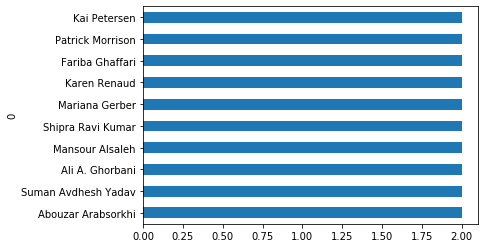

In [95]:
auth_col_list = list(df.columns[:6])
authdf = pd.DataFrame(df[auth_col_list])
authindex = pd.DataFrame(authdf.stack())
authindex.groupby([0]).size().sort_values().tail(10).plot(kind='barh')
#auth_series = pd.Series(df[auth_col_list].values.ravel()).dropna()
#auth_series

In [8]:
df.columns

Index(['author0', 'author1', 'author2', 'author3', 'author4', 'author5',
       'database', 'title', 'journal', 'citations', 'year', 'impact_factor'],
      dtype='object')

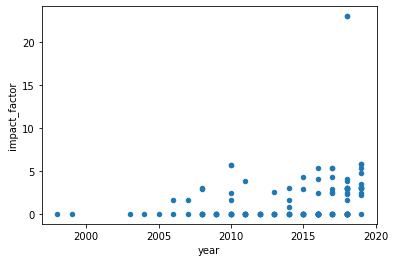

In [97]:
# Scatterplot
# X: highest impact factor
# Y: Impact factor, ascending

df[["impact_factor", "year"]].plot(kind='scatter', x='year', y='impact_factor')

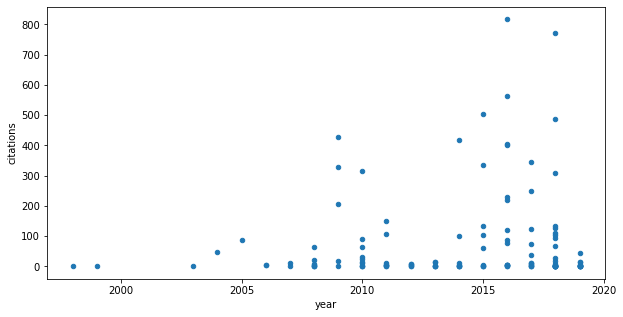

In [114]:
# Scatterplot citations and year
# X: year
# Y: Citations

df[["citations", "year"]].plot(kind='scatter', x='year', y='citations', figsize=(10,5))

In [99]:
list(df.columns[0:6])

['author0', 'author1', 'author2', 'author3', 'author4', 'author5']

In [92]:
# Melting all author columns into one column
melt_auth_df = df[list(df.columns[0:6])].melt(var_name='auth_id').set_index('auth_id')
melt_auth_df.dropna().groupby('value').size().sort_values(ascending=False)

value
Kai Petersen          2
Patrick Morrison      2
Fariba Ghaffari       2
Karen Renaud          2
Mariana Gerber        2
                     ..
Neeraj Kumar          1
Nicolas Vavasseur     1
Noam Ben-Asher        1
Nobutoshi Hatanaka    1
A. Hunstad            1
Length: 367, dtype: int64

**Keywords**

In [8]:
df.columns

Index(['author0', 'author1', 'author2', 'author3', 'author4', 'author5',
       'keywords0', 'keywords1', 'keywords10', 'keywords11', 'keywords12',
       'keywords13', 'keywords14', 'keywords15', 'keywords16', 'keywords17',
       'keywords18', 'keywords19', 'keywords2', 'keywords20', 'keywords21',
       'keywords3', 'keywords4', 'keywords5', 'keywords6', 'keywords7',
       'keywords8', 'keywords9', 'database', 'title', 'journal', 'citations',
       'year', 'impact_factor'],
      dtype='object')

In [115]:
# Get the most used keywords

# Combine the keywordcolumns into one series
#Melting!!
# Search for the most used one 

melt_key = df[list(df.columns[6:28])].melt().drop("variable", axis=1)
melt_df = melt_key["value"].dropna().str.lower()
melt_70_dict = melt_df.value_counts().head(70).to_dict()
WordCloud(background_color="black").generate_from_frequencies(frequencies=melt_70_dict)

#.plot(kind='barh', figsize=(7, 14))
#.groupby("value").size().sort_values(ascending=False).head(50).plot(kind='barh', figsize=(7,12))

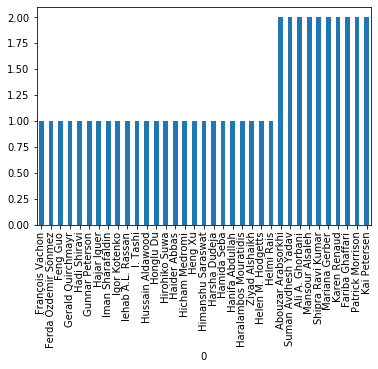

In [101]:
# Number of studies per author
# Most published authors
# extracting the authorcolumns from the df
auth_col_list = list(df.columns[:6])
authdf = pd.DataFrame(df[auth_col_list])
authindex = pd.DataFrame(authdf.stack())
authindex.groupby([0]).size().sort_values().tail(35).plot(kind='bar')
#auth_series = pd.Series(df[auth_col_list].values.ravel()).dropna()
#auth_series

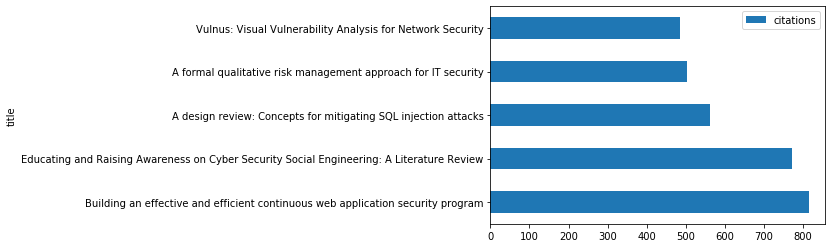

In [102]:
# Most cited paper plus distribution of citations
df[["citations", "title"]].sort_values(
    by="citations",
    ascending=False).head().set_index('title').plot(kind='barh')

In [25]:
df[["citations", "title"]].sort_values(by="citations",
                                      ascending=False)

,citations,title
126,817,Building an effective and efficient continuous...
130,773,Educating and Raising Awareness on Cyber Secur...
50,562,A design review: Concepts for mitigating SQL i...
76,503,A formal qualitative risk management approach ...
10,486,Vulnus: Visual Vulnerability Analysis for Netw...
...,...,...
17,0,Information Security Metrics
16,0,Apparatus: A framework for security analysis i...
85,0,A control-theoretic perspective on cyber-physi...
89,0,Trade secrets and cyber security breaches


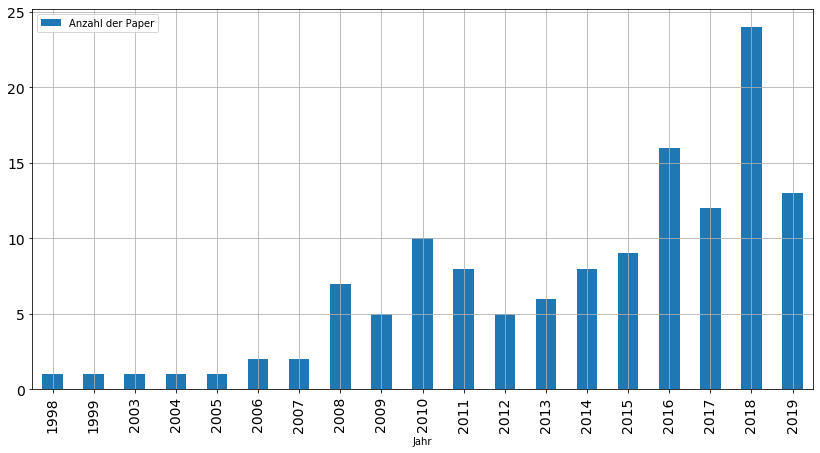

In [103]:
# Time series corelation. x: tiem in years, y: number of studies
time_correlation_gby = df.groupby("year").size()
time_corr_df = pd.DataFrame(time_correlation_gby)
time_corr_df.columns = ['Anzahl der Paper']
time_corr_df.index.name = 'Jahr'
time_corr_df.plot(kind='bar', figsize=(14, 7), grid=True, fontsize=14)

In [10]:
# Journal types. Journals of Conference

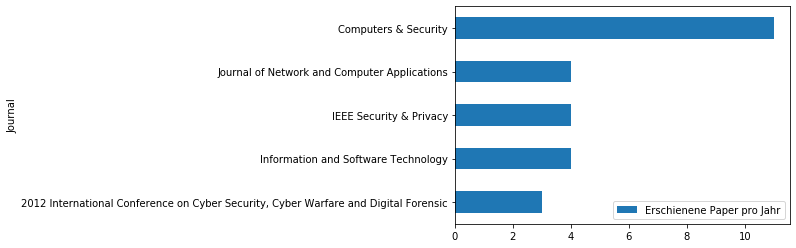

In [11]:
# Most published journals. Dropping all values with NotaJournal entry
df.loc[df["journal"].eq('Proceedings Title: 2012 International Conference on Cyber Security, Cyber Warfare and Digital Forensic (CyberSec)'), "journal"] = "2012 International Conference on Cyber Security, Cyber Warfare and Digital Forensic"
journal_gby = df.groupby("journal").size().drop('NaJ').sort_values().tail(5)
journal_time_journal_df = journal_gby.reset_index()
journal_time_journal_df.columns = ["Journal", "Erschienene Paper pro Jahr"]
journal_time_journal_df.set_index("Journal").plot(kind='barh')
# journal_plot = journal_time_journal_df.set_index("Journal").plot(kind='barh')


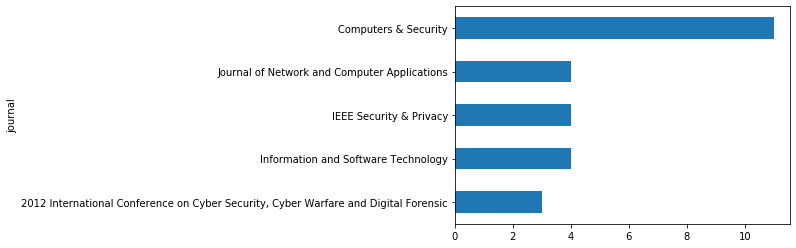

In [12]:
# Most published journals.

# Get the dataframe
# Get the amount of journals. Probably groupby
grp_journal = df.groupby("journal").size().drop('NaJ').sort_values().tail(5)
grp_journal.plot(kind='barh')

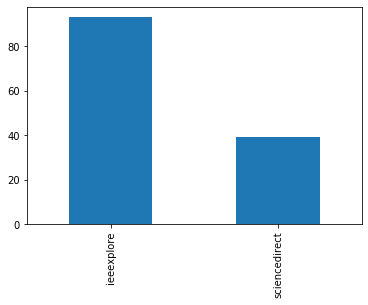

In [36]:
# Found papers in databases
used_databases = df["database"].value_counts()
used_databases.plot(kind='bar')

In [14]:
used_databases.to_csv('test.csv')

/home/zwoelfer/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [15]:
# Found conference papers. Usually withour an impact factor

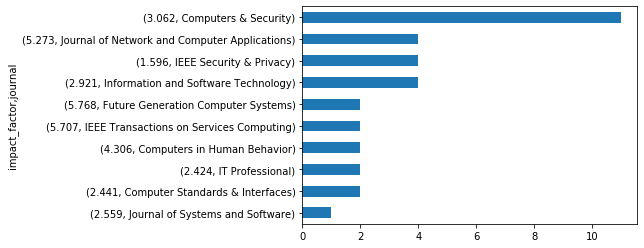

In [16]:
# Shows impact factors and journals that are most commonly used
df.groupby(["impact_factor", "journal"]).size().drop(0.000).sort_values().tail(
10).plot(kind='barh')

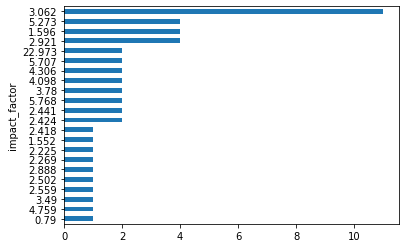

In [17]:
# Show highest impactfactors and journals used
# df.loc[:, ["journal", "impact_factor"]].sort_values(by="impact_factor").tail(18)
df.groupby("impact_factor").size().drop(0.000).sort_values().plot(kind='barh')